In [39]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

# Load the data into a Pandas dataframe
names = ['GRE Score', 'TOEFL Score','University Rating', 'SOP', 
         'LOR', 'CGPA', 'Research', 'Chance of Admit ']
data = pd.read_csv('../data/cleaned_data/cleaned_kaggle_grad_admissions.csv',)

data.head(6)

,Unnamed: 0,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,0,337,118,4,4.5,4.5,3.860,1,0.92
1,1,324,107,4,4.0,4.5,3.548,1,0.76
2,2,316,104,3,3.0,3.5,3.200,1,0.72
3,3,322,110,3,3.5,2.5,3.468,1,0.80
4,4,314,103,2,2.0,3.0,3.284,0,0.65
5,5,330,115,5,4.5,3.0,3.736,1,0.90


In [29]:

# Split the data into training and testing sets
X = data.iloc[:, -8:-1]  # select all columns except the last one
y = data.iloc[:, -1]   # select the last column
yAcc= y.apply(lambda x: 1 if x>0.5 else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Linear Regression (by Christoffel)

In [6]:
reg = LinearRegression().fit(X_train, y_train)
y_pred=reg.predict(X_test)
regSave = LinearRegression().fit(X, y)
with open('../model/LinearReg.pkl', 'wb') as file:
    pickle.dump(regSave, file)

### visualization

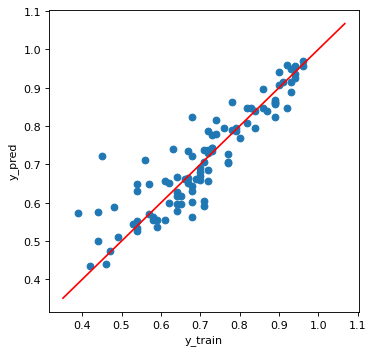

In [7]:
def visualization_for_predict_data(data_observed, data_predicted, label_observed, label_predicted):
    mpl.rcParams['figure.dpi']=80
    plt.rcParams['figure.figsize'] = [5,5]
    plt.scatter(data_observed, data_predicted)
    max_v = np.max([data_predicted] + [data_observed]) * 1.1
    min_v = np.min([data_predicted] + [data_observed]) * 0.9
    plt.plot([min_v,max_v], [min_v,max_v], "r-")
    plt.xlabel(label_observed)
    plt.ylabel(label_predicted)
visualization_for_predict_data(y_test, y_pred, "y_train", "y_pred")

In [10]:
def MSE_cal(obs,pred):
    assert len(obs)==len(pred)
    sumErr=0
    for i in range(len(pred)):
        squareErr=((pred[i]-obs.iloc[i])**2)
        sumErr+=squareErr
    return sumErr/len(pred)
MSE = MSE_cal(y_test,y_pred)
print(MSE)

0.0037046553987884106


In [26]:
def Accuracy_cal(obs,pred):
    assert len(obs)==len(pred)
    cnt=0
    if type(y_test)==type(np.array([])):
        for i in range(len(pred)):
            if pred[i]>0.5 and obs[i]>0.5:
                cnt+=1
            elif pred[i]<0.5 and obs[i]<0.5:
                cnt+=1
        return cnt/len(pred)
    else:
        for i in range(len(pred)):
            if pred[i]>0.5 and obs.iloc[i]>0.5:
                cnt+=1
            elif pred[i]<0.5 and obs.iloc[i]<0.5:
                cnt+=1
        return cnt/len(pred)
accuracy=Accuracy_cal(y_test,y_pred)
print(accuracy)

0.92


In [25]:
type(y_test)==type(np.array([]))

True

### only pick the gre and gpa features

In [6]:
X_trainG=X_train.iloc[:,[1,2,6]]
X_testG=X_test.iloc[:,[1,2,6]]
reg = LinearRegression().fit(X_trainG, y_train)
y_predG=reg.predict(X_testG)
MSE = MSE_cal(y_test,y_predG)
print(MSE)

0.004216051080066659


- If only pick the three features with highest correlation, MSE is worse than using all feartures
- This indicates that other features are still helpful for the prediction.

## Other models(by Chritoffel)
- DecisionTreeRegressor
- RandomForestRegressor
- XGBRegressor
- KNeighborsRegressor

### Standard scalar

In [41]:
scaler = StandardScaler()
dataArray=np.array(data)
Xdata=dataArray[:, :-1]
scaler.fit(Xdata)
standard_data = scaler.transform(Xdata)
# Split the data into training and testing sets
X = standard_data  # select all columns except the last one
y =dataArray[:, -1]   # select the last column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
classifiers = [
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    XGBRegressor(),
    KNeighborsRegressor(),
    ]
classiferName=['DecisionTreeRegressor','RandomForestRegressor','XGBRegressor','KNeighborsRegressor']
def MSE_cal(obs,pred):
    assert len(obs)==len(pred)
    sumErr=0
    for i in range(len(pred)):
        squareErr=((pred[i]-obs[i])**2)
        sumErr+=squareErr
    return sumErr/len(pred)
for i,classifier in enumerate(classifiers):
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train, y_train)
    y_pred=pipe.predict(X_test)
    MSE = MSE_cal(y_test,y_pred)
    Acc = Accuracy_cal(y_test,y_pred)
    print("{} MSE: {} Acc: {}" .format(classiferName[i],MSE,Acc))

DecisionTreeRegressor MSE: 0.006072999999999999 Acc: 0.94
RandomForestRegressor MSE: 0.003378526099999999 Acc: 0.95
XGBRegressor MSE: 0.003296978128710078 Acc: 0.94
KNeighborsRegressor MSE: 0.00399248 Acc: 0.93


# Random Forest model(by Tiff Wang)

In [18]:
# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

In [19]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)



In [20]:
# Evaluate the performance of the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)


Mean Squared Error: 0.0033273111999999982


Loss Function shows that the model is not learning from the training data. In other words, the performance of the model is not improving over time as more training iterations are performed. This is because of the insufficient data.

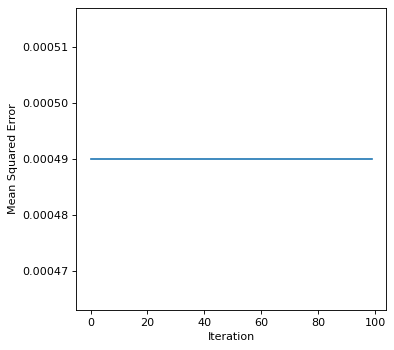

In [21]:
# Train the Random Forest model and keep track of the training loss
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
train_losses = []
for i in range(100):
    rf_model.fit(X_train, y_train)
    y_train_pred = rf_model.predict(X_train)
    train_loss = mean_squared_error(y_train, y_train_pred)
    train_losses.append(train_loss)

# Plot the training loss over time
plt.plot(train_losses)
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.show()


# Correlation

calculate the correlation between each feature and the target variable. Features with a higher correlation are more likely to have a greater impact on the prediction results.

In [7]:
# calculate correlation matrix
corr_matrix = X.corrwith(y)

# print correlation scores for each feature
print(corr_matrix)


GRE Score            0.810351
TOEFL Score          0.792228
University Rating    0.690132
SOP                  0.684137
LOR                  0.645365
CGPA                 0.882413
Research             0.545871
dtype: float64


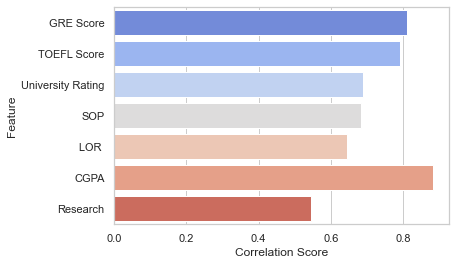

In [8]:
# calculate correlation matrix
corr_matrix = X.corrwith(y)

# plot correlation scores
sns.set(style="whitegrid")
ax = sns.barplot(x=corr_matrix.values, y=corr_matrix.index, palette="coolwarm")
ax.set(xlabel="Correlation Score", ylabel="Feature")
plt.show()


# Feature permutation importance

This method involves randomly shuffling the values of each feature and measuring the change in the prediction accuracy. Features that cause the greatest decrease in accuracy when shuffled are considered to be more important.

In [9]:
# fit a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# calculate feature importance
result = permutation_importance(rf, X, y, n_repeats=10, random_state=42)

# print the feature importance scores
print(result.importances_mean)


[0.11924543 0.05569972 0.02501786 0.04629195 0.04224017 0.97868606
 0.02808381]


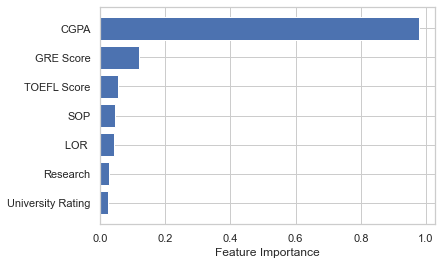

In [10]:
# plot feature importance scores
sorted_idx = result.importances_mean.argsort()
plt.barh(range(X.shape[1]), result.importances_mean[sorted_idx])
plt.yticks(range(X.shape[1]), X.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.show()
